In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras import layers, models, optimizers, metrics
tf.config.optimizer.set_jit(True)

In [5]:
from scipy.ndimage import convolve

class Connect4Game(object):
  def __init__(self):
    self.board = np.zeros((6, 7)).astype(np.int8)
    self.tops = np.zeros(7).astype(np.int8)
    self.moves_played = 0
    self.pieces = {1: "🔴",
                   0: "⬛",
                   -1:"🟡"}
  def render(self):
    for row in reversed(range(6)):
      print(''.join([self.pieces[i] for i in self.board[row].astype(np.int)]))
    print("1️⃣2️⃣3️⃣4️⃣5️⃣6️⃣7️⃣")
  def reset(self):
    self.board *= 0
    self.tops *= 0
    self.moves_played = 0
  def play(self, col, color):
    self.board[int(self.tops[col])][col] = color
    self.tops[col] += 1
    self.moves_played += 1
  def result(self):
    """ Returns 0 if it's a tie; returns None if the game is not over; returns -1 if player -1 wins, and 1 if player 1 wins."""
    if self.moves_played == 42: return 0
    kernel_row = [[1, 1, 1, 1]]
    kernel_col = [[1],
                  [1],
                  [1],
                  [1]]
    kernel_dia = [[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]
    kernel_dia2 = [[0, 0, 0, 1],
                  [0, 0, 1, 0],
                  [0, 1, 0, 0],
                  [1, 0, 0, 0]]
    for kernel in [np.array(kernel_row).astype(np.int8), np.array(kernel_col).astype(np.int8), np.array(kernel_dia).astype(np.int8), np.array(kernel_dia2).astype(np.int8)]:
      check = convolve(self.board, kernel, mode='constant')
      #print(check)
      if (check == 4).any(): return 1
      if (check == -4).any(): return -1
    return None 

In [48]:
from PIL import Image
from collections import defaultdict
import random
import time, tqdm

def softmax(x, temperature=1):
    return np.exp(x/temperature)/sum(np.exp(x/temperature))

class A0(object):
    def __init__(self, name, model_complexity = 2, n_simulations = 64, model = None):
        # Hyperparameters
        self.n_simulations = n_simulations # Keep it simple
        self.c = 1 # weight for exploration
        self.n_parallel = os.cpu_count()
        
        # Basic
        self.name = name
        self.simulator = Connect4Game() # Would be different if this were muzero
        self.model_complexity = model_complexity # 1+
        if model == None:
            self.model = self.create_model(conv_layers = self.model_complexity, describe = True)
        else:
            print("Loading model from memory.")
            self.model = model
        
        # Monte Carlo Tree Search stuff
        self.visited = set()
        self.Q, self.P, self.N = defaultdict(lambda: np.zeros(7).astype(np.float32)), {}, defaultdict(lambda: np.zeros(7).astype(np.uint8))

        
    def create_model(self, conv_layers = 2,describe = False):
        in_ = layers.Input((6, 7, 1))
        X = layers.Conv2D(32, (4,4), activation = 'relu', padding = "same")(in_)
        for i in range(conv_layers-1):
            X_skip = layers.Conv2D(32, (3,3), activation = 'relu', padding = "same")(X)
            X_skip = layers.BatchNormalization()(X_skip)
            X_skip = layers.Conv2D(32, (2,2), activation = 'relu', padding = "same")(X_skip)
            X_skip = layers.BatchNormalization()(X_skip)
            X = layers.BatchNormalization()(X)
            X = layers.Add()([X_skip, X])
        X = layers.Conv2D(32, (2,2), activation = 'relu')(X)
        X = layers.BatchNormalization()(X)
        #X = layers.GlobalAveragePooling2D()(X)
        X = layers.Flatten()(X)
        #P = layers.Dense(32, activation = 'relu')(X)
        P = layers.Dense(7, activation = 'softmax', name = "P_head")(X) # Check the activations here
        Q = layers.Dense(8, activation = 'relu')(X)
        Q = layers.Dense(1, activation = 'tanh', name = "Q_head")(Q)
        model = models.Model(in_, [P, Q])
        model.compile(optimizer=optimizers.Adam(0.001), loss={'P_head': "binary_crossentropy", 'Q_head': "mse"})
        
        if describe: 
            tf.keras.utils.plot_model(
                model,
                to_file="model.png",
                show_shapes=True,
                show_dtype=True,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=False,
                dpi=120,
                layer_range=None,
                show_layer_activations=True,
            )
            img = Image.open("model.png")
            wpercent = (750/float(img.size[0]))
            hsize = int((float(img.size[1])*float(wpercent)))
            img = img.resize((750,hsize), Image.Resampling.LANCZOS)
            display(img)
            
            trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
            nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
            totalParams = trainableParams + nonTrainableParams

            print("Trainable parameters:", trainableParams)
            print("Untrainable parameters:",nonTrainableParams)
            print("Total parameters:",totalParams)
        return model        
    
    def MCTS(self, game, turn):
        self.simulator.board = game.board
        self.simulator.tops = game.tops
        self.simulator.moves_played = game.moves_played
        
        if self.simulator.result() != None: return -self.simulator.result() * turn # It's over, Anakin!
        # TODO: CHECK HOW THE ABOVE INTERACTS WITH THE SIGN SWITCHING
        s = self.simulator.board * turn
            
        if s.tobytes() not in self.visited:
            """
            Let's be very clear about this. The model is NOT TURN AGNOSTIC: the board is flipped to encode the active 
            player's pieces as 1 at all times.
            
            The Q head of the model predicts the quality of the board between 1 and -1 (thus the tanh activation).
            Positions more favored for the current player have qualities approaching 1; positions favored for the
            adversary have qualities approaching -1. 
            
            The P head of the model predicts how promising each action is for the current player. Note that
            keeping the model turn agnostic would necessitate passing in the current turn to the P head (as to denote
            the player whose moves' potentials would have to be calculated) and lay an unnecessary burden upon the P network.
            
            Also, the tanh activation and (1, -1) encoding is so that multiplying v by -1 yields v for the opponent (convenient!)
            """
            self.visited.add(s.tobytes())
            # self.P[s.tobytes()], v = np.ones(7)/7, 0 #DEBUG ONLY
            
            p_, v_ = self.model(s[np.newaxis, :, :, np.newaxis]) # Why not save v as the starting value for Q[s][a], you may ask?
                        # Because that injects bias into the MCTS, and we want to keep the "pure" MCTS output to boost the model.
                        # Essentially, we want to minimize the potential for feedback loops as much as possible (model predicting
                        # high initial quality, MCTS outputting high initial quality and prodicing biased games, etc).
            self.P[s.tobytes()] = p_[0]
            v = v_[0]
                        
            return -v # Invert the quality. Let's imagine it's move 0 (the board state in the real game). On MCTS call 1, 
                        # the function returns -v (v = network at-a-glance), which is fine, since we don't care about the output 
                        # (only used to calculate N). On call 2, the function goes to the next move and evaluates the board for 
                        # the opponent (let's dub this o.) -o, or v, gets returned, and then v is used to update N and Q, before
                        # -v being returned to the main function. Notice that the value used to update N is always +v.
        
        legal_moves = [i for i in range(7) if game.tops[i] != 6]
        
        s = s.tobytes() # make it hashable
        best_a = random.choice(legal_moves) # inject randomness instead of using [0] to avoid making any one move extra prevalent in the case of a tie
        best_u = -float("inf")
        u_s, a_s = [],[]
        for a in legal_moves: # legal moves
            u = self.Q[s][a] + self.c * self.P[s][a] * np.sqrt(np.sum(self.N[s]))/(1+self.N[s][a]) # upper confidence bound (UCB) 
            u_s.append(u)
            if u > best_u: 
                best_u = u
                
        a = random.choice([legal_moves[index] for index, u in enumerate(u_s) if u == best_u]) 
        
        self.simulator.play(a, turn)
        v = self.MCTS(self.simulator, -turn)
        
        self.Q[s][a] = (self.N[s][a] * self.Q[s][a] + v) / (self.N[s][a] + 1) # Recalculate Q as the average quality
        self.N[s][a] += 1
        
        return -v
    
    def play_episode(self, temperature, debug = False):        
        game = Connect4Game()
        turn = 1
        
        # Data
        p1_states, pneg1_states = [], []
        p1_policies, pneg1_policies = [], []
        
        if debug: times = []
        while (game.result() == None):
            
            for i in range(self.n_simulations):
                if debug: starttime = time.time()
                    
                copy_game = Connect4Game()
                # Pass by copy (we don't want the internal MCTS to modify the outer game)
                copy_game.board = game.board.copy()
                copy_game.tops = game.tops.copy()
                copy_game.moves_played = game.moves_played # integer
                self.MCTS(copy_game, turn)
        
                if debug: times.append(time.time() - starttime)
                        
            s = (game.board * turn).tobytes()
            assert(np.sum(self.N[s]) == self.n_simulations-1)
            
            probs = np.log(self.N[s]+0.01)
            probs = softmax(probs, temperature = temperature)
            probs = np.array([probs[a] if game.tops[a] != 6 else 0 for a in range(7)])
                        
            self.visited.clear() # Reset tree
            if debug: 
              print("Turn: ", turn)
              game.render()
              print(self.N[s])
            self.N.clear()
            self.Q.clear()
            self.P.clear()
            
            probs *= (1/np.sum(probs))
            if debug: print(probs)
            
            # Double check if the agents are supposed to move based on their MCTS qualities or their predicted policy.
                        
            # Also double check if the policy network is supposed to be trained on the valid policy weights (softmaxed) 
            # as I do here (is it too burdensome to train the policy network using only the valid part of the MCTS policy distribution?)
            
            assert turn == 1 or turn == -1
            if turn == 1:
                p1_policies.append(probs)
                p1_states.append((game.board * turn)[:,:,np.newaxis])
            if turn == -1:
                pneg1_policies.append(probs)
                pneg1_states.append((game.board * turn)[:,:,np.newaxis])
            action = np.random.choice(range(0, 7), p = probs)
            game.play(action, turn)

            turn *= -1
        
        states = p1_states + pneg1_states # Label all qualities of the states from the pov of player 1 as 1 if p1 wins, -1 otherwise
        Q_target = [game.result()]*len(p1_states) + [-game.result()]*len(pneg1_states) # Label all qualities of the states from the pov of player -1 as -1 if p1 wins, 1 otherwise
        P_target = p1_policies + pneg1_policies # Match up with the states and Q target
        if debug: print("Average MCTS time:", sum(times) / len(times))
            
        return states, P_target, Q_target
    
    def fit(self, data, batch_size, epochs):
        
        states, P_target, Q_target = data
        
        self.new = self.create_model(conv_layers = self.model_complexity, describe = False)
        self.new.set_weights(self.model.get_weights())
        self.new.fit(x = np.array(states), y = {"Q_head": np.array(Q_target), "P_head": np.array(P_target)}, batch_size = batch_size, epochs = epochs, shuffle = True)
        return self.new
    
    def make_move(self, game, turn, temperature = 0.1, n_simulations = None, display = True):
        if n_simulations == None: simulations = self.n_simulations
        else: simulations = n_simulations
        for i in range(simulations):
            copy_game = Connect4Game()
            # Pass by copy (we don't want the internal MCTS to modify the outer game)
            copy_game.board = game.board.copy()
            copy_game.tops = game.tops.copy()
            copy_game.moves_played = game.moves_played # integer
            v = self.MCTS(copy_game, turn)
        s = (game.board * turn).tobytes()

        assert(np.sum(self.N[s]) == simulations-1)

        probs = np.log(self.N[s]+0.01)
        probs = softmax(probs, temperature = temperature)
        probs = np.array([probs[a] if game.tops[a] != 6 else 0 for a in range(7)])
        probs *= (1/np.sum(probs))

        action = np.random.choice(range(0, 7), p = probs)
        if display:
            print("Turn: ", turn)
            p_, v_ = self.model((game.board * turn)[np.newaxis, :, :, np.newaxis])
            np.set_printoptions(precision=3, suppress=True)
            
            print("Heuristics:\nMove probabilities:",p_[0].numpy())
            print("Est. Score (1 = win, -1 = loss):",v_[0].numpy()[0])
            print("On second thought:\nMove probabilities:",probs)
            print("Est. Score (1 = win, -1 = loss):",v.numpy()[0] if type(v) != int else v)
            print("# explored moves for each position: ", self.N[s])

        self.visited.clear() # Reset tree
        self.N.clear()
        self.Q.clear()
        self.P.clear()
        
        return action

In [49]:
class A0_nodepth:
    def __init__(self, name, model_complexity = 2, model = None):
            # Basic
            self.name = name
            self.simulator = Connect4Game() # Would be different if this were muzero
            self.model_complexity = model_complexity # 1+
            if model == None:
                self.model = self.create_model(conv_layers = self.model_complexity, describe = True)
            else:
                print("Loading model from memory.")
                self.model = model
                
    def make_move(self, game, turn, temperature = 0.8, n_simulations = None, display = False):
        p_, v_ = self.model((game.board * turn)[np.newaxis, :, :, np.newaxis])
        probs = np.log(p_[0])
        probs = softmax(probs, temperature = temperature)
        probs = np.array([probs[a] if game.tops[a] != 6 else 0 for a in range(7)])
        probs *= (1/np.sum(probs))

        action = np.random.choice(range(0, 7), p = probs)
        if display:
            print("Turn: ", turn)
            print("Heuristics:",p_[0].numpy(), v_[0].numpy())
        return action

In [58]:
# Evaluate
import random

class Ladder(object):
    def __init__(self):
        self.game = Connect4Game()
    def play_match(self, player_1, player_neg1, render = False):
        turn = 1
        self.game.reset()
        while (self.game.result() == None):
            if render: self.game.render()
            
            if turn == 1:
                action = player_1.make_move(self.game, turn)
            if turn == -1:
                action = player_neg1.make_move(self.game, turn)
            self.game.play(action, turn)
            
            turn *= -1

            
        result = self.game.result()
        if render: 
            self.game.render()
            print("GAME OVER!")
            if result == 1: print("Red player wins!")
            if result == -1: print("Yellow player wins!")
            if result == 0: print("It's a tie!")

        self.game.reset()
        return result
    
    def play_tournament(self, players, NUM_MATCHES = 1000, K = 16, onesd = 400):
        MMR = {}
        for player in players:
            MMR[player.name] = 1000
        for match in tqdm.trange(NUM_MATCHES):
            p1, p_neg1 = random.sample(players, 2)
            result = self.play_match(p1, p_neg1)
            
            SA = (result + 1) / 2 # A scores 1 point if win, 0 points if loss.
            SB = (-result + 1) / 2 # B scores 1 point if win, -1 points if loss.
            # Both score 0.5 points if tie.
            EA = 1 / (1 + 10**((MMR[p_neg1.name] - MMR[p1.name]) / onesd))
            EB = 1 / (1 + 10**((MMR[p1.name] - MMR[p_neg1.name]) / onesd))
            
            MMR[p1.name] = MMR[p1.name] + K * (SA - EA)
            MMR[p_neg1.name] = MMR[p_neg1.name] + K * (SB - EB)
        new_MMR = {}
        for key in MMR:
            new_MMR[key] = 1000 + MMR[key] - MMR["Random"]
        return new_MMR

In [59]:
class human_player():
    def __init__(self):
        pass
    def make_move(self, game, turn):
        legal_moves = [i for i in range(7) if game.tops[i] != 6]
        while True:
            print("Your turn:",turn)
            game.render()
            move = int(input())-1
            if move in legal_moves: break
            else: print("That's not a legal move.")
        return move

In [60]:
model = models.load_model("Remote/v3_Boosted.h5", compile = False)
model.compile(optimizer=optimizers.Adam(0.001), loss={'P_head': "binary_crossentropy", 'Q_head': "mse"})

In [53]:
agent = A0_nodepth("heuristic", 6, model)

Loading model from memory.


In [61]:
agent = A0("agent", 12, 64, model)
agent_2 = A0("adversary", 12, 84, model)

Loading model from memory.
Loading model from memory.


In [62]:
agent.c = 5
agent_2.c = 5

In [63]:
ladder = Ladder()

In [64]:
ladder.play_match(agent,agent_2,render = True)


C:\Users\william\AppData\Local\Temp\ipykernel_7368\1414013612.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(''.join([self.pieces[i] for i in self.board[row].astype(np.int)]))


⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛⬛⬛
1️⃣2️⃣3️⃣4️⃣5️⃣6️⃣7️⃣
Turn:  1
Heuristics:
Move probabilities: [0.003 0.004 0.004 0.973 0.005 0.005 0.006]
Est. Score (1 = win, -1 = loss): 0.065749936
On second thought:
Move probabilities: [0. 0. 0. 1. 0. 0. 0.]
Est. Score (1 = win, -1 = loss): 0.24134068
# explored moves for each position:  [ 0  0  1 62  0  0  0]
⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛🔴⬛⬛⬛
1️⃣2️⃣3️⃣4️⃣5️⃣6️⃣7️⃣
Turn:  -1
Heuristics:
Move probabilities: [0.004 0.008 0.007 0.967 0.003 0.004 0.006]
Est. Score (1 = win, -1 = loss): -0.19095679
On second thought:
Move probabilities: [0. 0. 0. 1. 0. 0. 0.]
Est. Score (1 = win, -1 = loss): -0.016984036
# explored moves for each position:  [ 0  1  0 82  0  0  0]
⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛⬛⬛⬛⬛
⬛⬛⬛🟡⬛⬛⬛
⬛⬛⬛🔴⬛⬛⬛
1️⃣2️⃣3️⃣4️⃣5️⃣6️⃣7️⃣
Turn:  1
Heuristics:
Move probabilities: [0.005 0.005 0.029 0.018 0.483 0.454 0.006]
Est. Score (1 = win, -1 = loss): 0.06079538
On second thought:
Move probabilities: [0.    0.    0.    0.    0.

-1

In [34]:
players = []
DEPTH = 49
for i in range(1,50):
    model = models.load_model('MachineTest/Epoch'+str(i)+'.h5', compile = False)
    model.compile(optimizer=optimizers.Adam(0.001), loss={'P_head': "binary_crossentropy", 'Q_head': "mse"})
    players.append(A0('v3_Epoch_'+str(i), 6, DEPTH, model))
        #A0_nodepth('v3_Epoch_'+str(i),6, model))
class RandomPlayer(object):
    def __init__(self, name = "Random"):
        self.name = name
    def norm_probs(self, probs, tops):
        probs *= (tops != 6)
        probs *= (1 / np.sum(probs))
        return probs
    def make_move(self, game, turn):
        probs = np.ones(7) / 7
        probs = self.norm_probs(probs, game.tops)
        return np.random.choice(range(0, 7), p = probs)
players.append(RandomPlayer())
#model = models.load_model("Remote/v3_Boosted.h5")
#players.append(A0('v3_Boosted', 6, DEPTH, model))
    #A0_nodepth('V3_Boosted',6, model))

Loading model from memory.
Loading model from memory.
Loading model from memory.
Loading model from memory.


OSError: No file or directory found at MachineTest/Epoch5.h5

In [44]:
ladder = Ladder()

In [ ]:
results = ladder.play_tournament(players, K = 400, NUM_MATCHES = 100)

 72%|████████████████████████████████████████████████████████▏                     | 72/100 [1:08:27<51:15, 109.85s/it]

In [ ]:
results['v3_Epoch_16'] = results['v3_Boosted'] 

In [40]:
results

{'v3_Epoch_1': 1212.6838712164285,
 'v3_Epoch_2': 1266.2220095196726,
 'v3_Epoch_3': 1453.2119974993707,
 'v3_Epoch_4': 1392.4627390012124,
 'v3_Epoch_5': 1419.18194347816,
 'v3_Epoch_6': 1385.6627525367412,
 'v3_Epoch_7': 1473.695297896697,
 'v3_Epoch_8': 1394.9221299563724,
 'v3_Epoch_9': 1587.3747259999286,
 'v3_Epoch_10': 1464.2491137566194,
 'v3_Epoch_11': 1573.9663995963197,
 'v3_Epoch_12': 1565.000113322334,
 'v3_Epoch_13': 1440.5257503284129,
 'v3_Epoch_14': 1423.943716716693,
 'v3_Epoch_15': 1585.616491367458,
 'Random': 1000.0000000000001,
 'v3_Boosted': 1595.8570463493093,
 'v3_Epoch_16': 1595.8570463493093}

In [41]:
baseline_results = {'v3_Epoch_1': 1071.560978669389,
 'v3_Epoch_2': 1158.3984801667766,
 'v3_Epoch_3': 1172.136020116286,
 'v3_Epoch_4': 1241.724793345752,
 'v3_Epoch_5': 1322.5102766599723,
 'v3_Epoch_6': 1295.6323713595716,
 'v3_Epoch_7': 1420.2875324110491,
 'v3_Epoch_8': 1400.9242170523535,
 'v3_Epoch_9': 1476.8973340235748,
 'v3_Epoch_10': 1448.0126204771827,
 'v3_Epoch_11': 1425.1173682856129,
 'v3_Epoch_12': 1425.9147777621524,
 'v3_Epoch_13': 1463.8800688419155,
 'v3_Epoch_14': 1363.9386623192977,
 'v3_Epoch_15': 1421.9380051389985,
 'Random': 1000.0,
 'V3_Boosted': 1448.4124823091965,
 'v3_Epoch_16': 1448.4124823091965}

depth_7_results = {'v3_Epoch_1': 1212.6838712164285,
 'v3_Epoch_2': 1266.2220095196726,
 'v3_Epoch_3': 1453.2119974993707,
 'v3_Epoch_4': 1392.4627390012124,
 'v3_Epoch_5': 1419.18194347816,
 'v3_Epoch_6': 1385.6627525367412,
 'v3_Epoch_7': 1473.695297896697,
 'v3_Epoch_8': 1394.9221299563724,
 'v3_Epoch_9': 1587.3747259999286,
 'v3_Epoch_10': 1464.2491137566194,
 'v3_Epoch_11': 1573.9663995963197,
 'v3_Epoch_12': 1565.000113322334,
 'v3_Epoch_13': 1440.5257503284129,
 'v3_Epoch_14': 1423.943716716693,
 'v3_Epoch_15': 1585.616491367458,
 'Random': 1000.0000000000001,
 'v3_Boosted': 1595.8570463493093,
 'v3_Epoch_16': 1595.8570463493093}

C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'ELO')

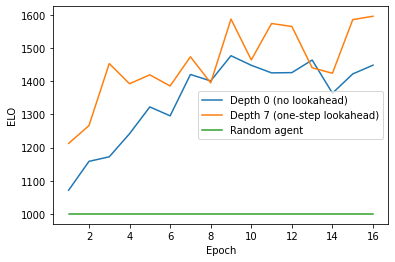

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(range(1,17), [baseline_results['v3_Epoch_'+str(i)] for i in range(1, 17)], label = "Depth 0 (no lookahead)")
sns.lineplot(range(1,17), [depth_7_results['v3_Epoch_'+str(i)] for i in range(1, 17)], label = "Depth 7 (one-step lookahead)")
sns.lineplot(range(1,17), 1000, label = "Random agent")
plt.xlabel("Epoch")
plt.ylabel("ELO")

In [ ]:
def play_match(agent, challenger):
    agent_turn = (random.randint(0, 1) * 2) - 1
    game = Connect4Game()
    turn = 1
    while (game.result() == None):
        for i in range(agent.n_simulations):
            starttime = time.time()

            copy_game = Connect4Game()
            # Pass by copy (we don't want the internal MCTS to modify the outer game)
            copy_game.board = game.board.copy()
            copy_game.tops = game.tops.copy()
            copy_game.moves_played = game.moves_played # integer
            if turn == agent_turn: agent.MCTS(copy_game, turn)
            else: challenger.MCTS(copy_game, turn)

        s = (game.board * turn).tobytes()
        
        if turn == agent_turn:
            move_qualities = np.array([agent.N[s][a] if game.tops[a] != 6 else 0 for a in range(7)])

            agent.visited.clear() # Reset tree
            # game.render() DEBUG
            agent.N.clear()
            agent.Q.clear()
            agent.P.clear()

        else:
            move_qualities = np.array([challenger.N[s][a] if game.tops[a] != 6 else 0 for a in range(7)])

            challenger.visited.clear() # Reset tree
            # game.render() DEBUG
            challenger.N.clear()
            challenger.Q.clear()
            challenger.P.clear()

        probs = move_qualities / (np.sum(move_qualities) + 0.00001)
        probs *= (1/np.sum(probs))

        action = np.random.choice(range(0, 7), p = probs)
        game.play(action, turn)

        turn *= -1
    if game.result() == agent_turn:
        return (1,0)
    elif game.result() == -agent_turn:
        return (0,1)
    else:
        return (0.5,0.5)